# Network Intrusion Detection using Random Forest Classifier

## Importing Necessary Libraries
In the field of cyber security, Intrusion Detection Systems (IDS) play a crucial role in identifying and preventing cyber attacks. Given the vastness of data and increasing sophistication of these attacks, the use of Machine Learning (ML) algorithms for intrusion detection is now a widely accepted practice. This script focuses on implementing an ML-based IDS using Python's scikit-learn library.

This project implements a supervised machine learning approach using the RandomForest Classifier for the detection of network intrusions. This algorithm is chosen for its strong predictive performance and capability to handle large datasets with high dimensionality.

The dataset used in this project is the KDD Cup 1999 Data, a well-known dataset in the network intrusion detection domain. The dataset includes a wide variety of intrusions simulated in a military network environment.

The whole process includes data preprocessing, feature selection, model training, and evaluation of the results.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, make_scorer, roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import mutual_info_classif
import re
import plotly.graph_objs as go
import plotly.subplots as sp
import matplotlib.cm as cm
from sklearn.decomposition import PCA

In [ ]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

These two lines of code are used to suppress specific types of warnings that might arise during the execution of your Python program.

In [ ]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

## Loading Dataset

In [ ]:
train_data = pd.read_csv('kdd_train.csv')
test_data = pd.read_csv('kdd_test.csv')

In [ ]:
print("Shape of Train Data: ", train_data.shape)
print("Shape of Test Data: ", test_data.shape)

Shape of Train Data:  (125973, 42)
Shape of Test Data:  (22544, 42)


In [ ]:
train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


## EDA

#### Missing Values in both Train and Test Data.

This code is used to visualize missing data in the training and testing datasets.

Heatmaps are powerful graphical representations where individual values are represented as colors. In this context, they are used to display whether a data point is null (missing) or not.

The sns.heatmap() function is utilized with the .isnull() method, which returns a DataFrame of Booleans indicating whether each data point is missing. The heatmaps created for the training and testing datasets show where the data is missing as different color representations. This visualization makes it easier to see patterns of missing data across the datasets and can help inform preprocessing strategies like imputation.

The two heatmaps are displayed side by side (in two subplots) for a better comparison between the patterns of missing data in the training and testing sets.

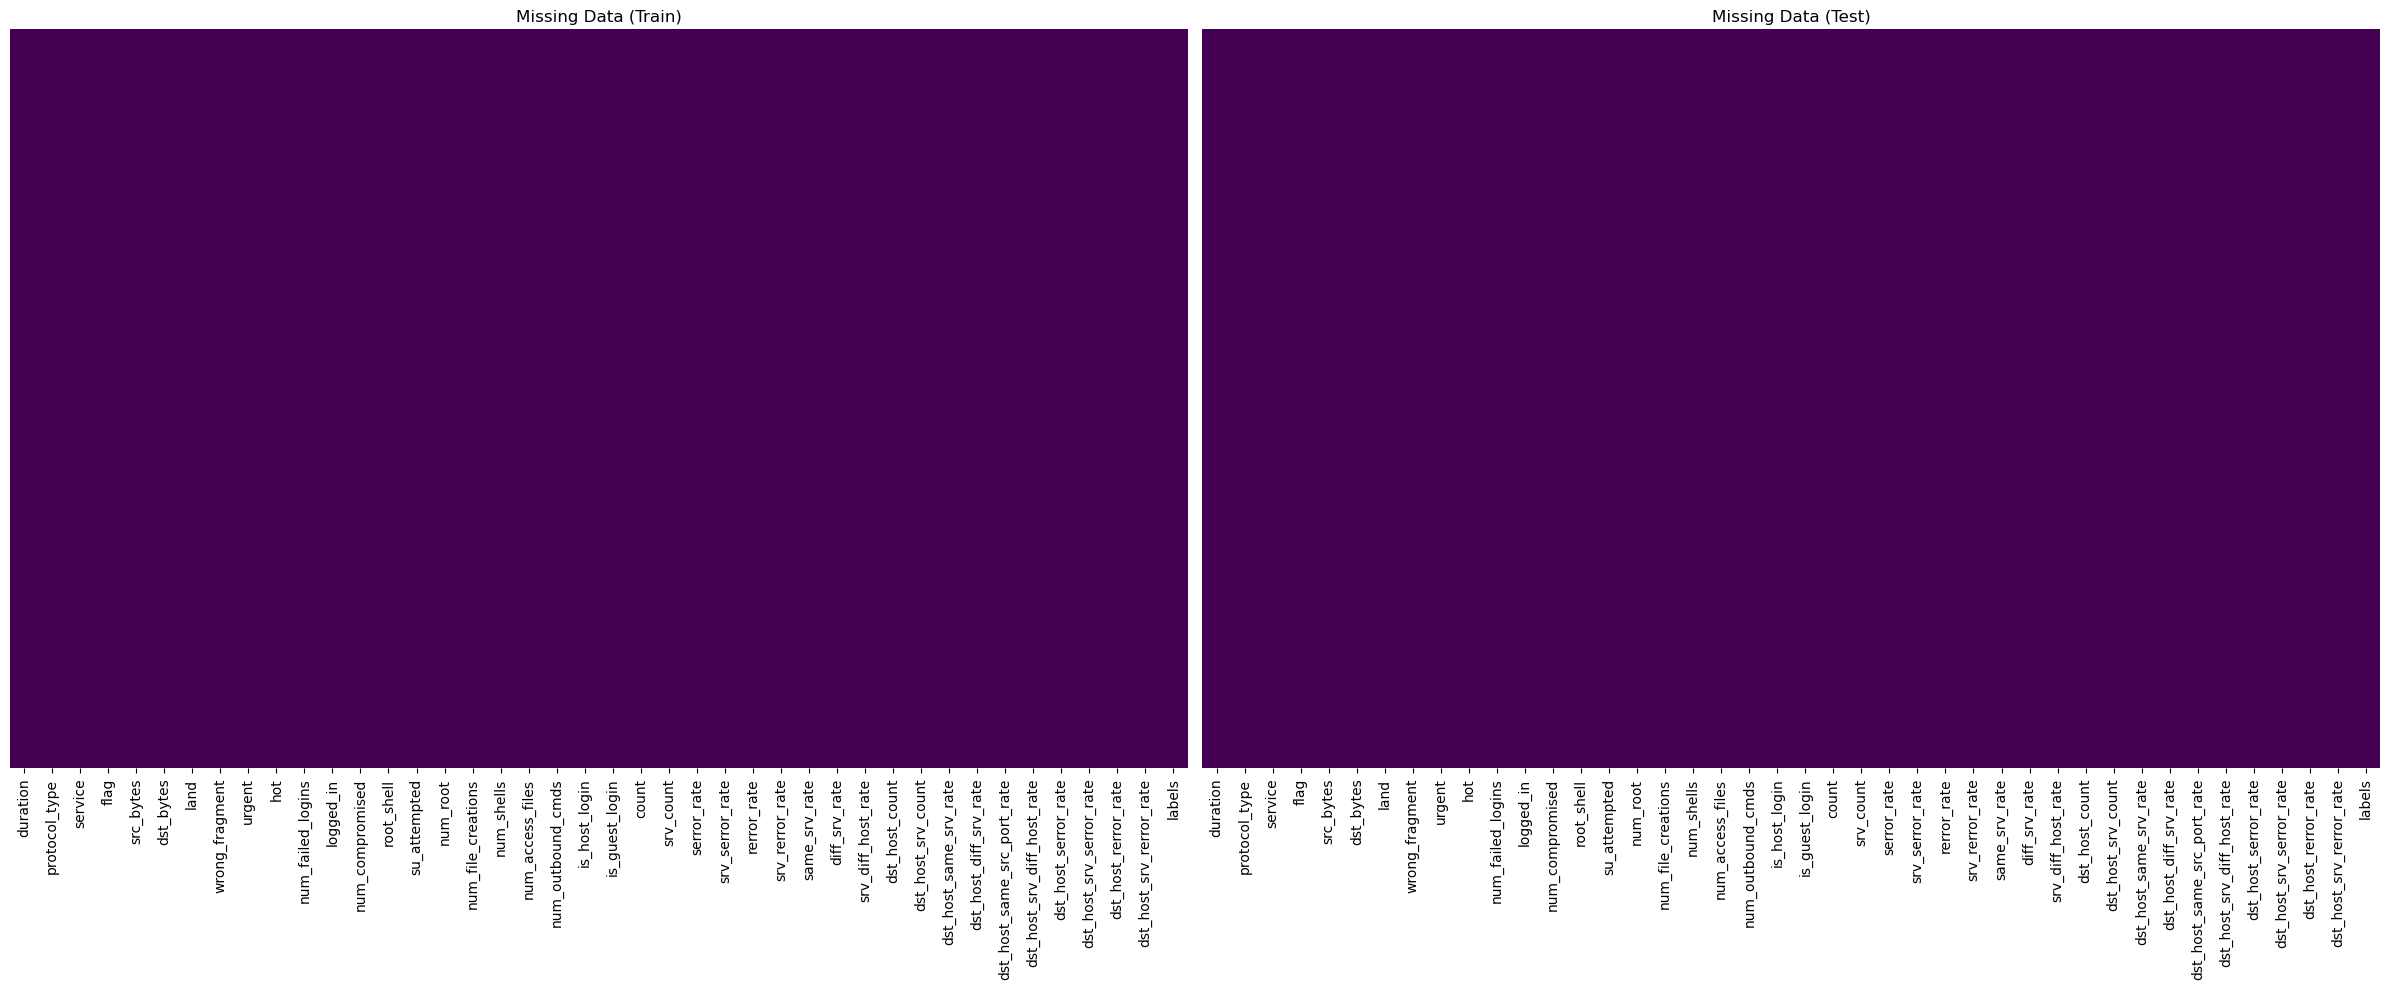

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# TO see the Heatmap
# Train Data
# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))

# Missing data in the training set
sns.heatmap(train_data.isnull(), cmap='viridis', cbar=False, yticklabels=False, ax=axes[0])
axes[0].set_title('Missing Data (Train)')

# Missing data in the testing set
sns.heatmap(test_data.isnull(), cmap='viridis', cbar=False, yticklabels=False, ax=axes[1])
axes[1].set_title('Missing Data (Test)')

# Display the plots
plt.tight_layout()
plt.show()

#### The above diagram clearly shows that there are no any missing values in both train and test data.

### Identify Categorical and Numerical Columns


The provided code is used to identify and separate categorical and numerical features in a given dataset, specifically 'train_data' in this case.

1. cat_features contains column names of features that are categorical (string or object type) in the dataset.
2. num_features holds column names of numerical features (float or int64 type).
3. input_cat_features includes all categorical features excluding the target or 'labels'.
4. target_cat_features isolates the target feature which is assumed to be the last column in the categorical features.

In [ ]:
cat_features = train_data.select_dtypes(include=["object"]).columns
num_features = train_data.select_dtypes(include=["float", "int64"]).columns
input_cat_features = cat_features.drop("labels")
target_cat_features = cat_features[-1]

In [ ]:
print("Categorical Features: ", cat_features, "\n")
print("Numerical  Features: ", num_features, "\n")
print("Input Categorical Features: ", input_cat_features, "\n")
print("Target Categorical Features: ", target_cat_features)

Categorical Features:  Index(['protocol_type', 'service', 'flag', 'labels'], dtype='object') 

Numerical  Features:  Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object') 

Input Categorical Features:  Index(['protocol_type', 'service', 'flag'], dtype='ob

In [ ]:
def split_dataset(data):
    X = data.drop(target_cat_features, axis=1)
    y = data[target_cat_features]

    return X, y

In [ ]:
X_train, y_train = split_dataset(train_data)
X_test, y_test = split_dataset(test_data)

In [ ]:
print(y_test.head())

0       normal
1       normal
2       normal
3       normal
4    portsweep
Name: labels, dtype: object


### Value Counts for OHE

Since we need to conver the categorical features into the numerical format, we need to perform One HOt Encoding (OHE). For this less frequent values are eliminated and replace with a same feature name.

In [ ]:
print("-----Value Counts-----")
for i in input_cat_features:
    print(f"\n{i}:\n{train_data[i].value_counts()}")

-----Value Counts-----

protocol_type:
tcp     102689
udp      14993
icmp      8291
Name: protocol_type, dtype: int64

service:
http         40338
private      21853
domain_u      9043
smtp          7313
ftp_data      6860
             ...  
tftp_u           3
http_8001        2
aol              2
harvest          2
http_2784        1
Name: service, Length: 70, dtype: int64

flag:
SF        74945
S0        34851
REJ       11233
RSTR       2421
RSTO       1562
S1          365
SH          271
S2          127
RSTOS0      103
S3           49
OTH          46
Name: flag, dtype: int64


#### Defining the function to handle less frequent values

In [ ]:
def replace_less_frequent_values(column_name, threshold, dataset):
    # df = df.copy()
    value_counts = dataset[column_name].value_counts()
    less_frequent_values = value_counts[value_counts <= threshold].index
    return dataset[column_name].apply(lambda x: f'less_often_{column_name}' if x in less_frequent_values else x)

Here service has 70 unique values, so we are separating the less frequent ones

In [ ]:
X_train[input_cat_features[1]] = replace_less_frequent_values(input_cat_features[1], 600, X_train)
X_test[input_cat_features[1]] = replace_less_frequent_values(input_cat_features[1], 600, X_test)

In [ ]:
X_train["service"].sample(10)

89939                private
88969                 finger
1675                    http
5795                 private
109783                  http
26593                   http
8696      less_often_service
103574               private
24703     less_often_service
7813                    http
Name: service, dtype: object

### Using Pipeline and Transformer
#### Making Different Transformer for Categorical and Numerical Data
numerical_transformer = Transformer for all the numerical features<br>
categorical_transformer = Transformer for all the categorical features


In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(sparse_output = False, handle_unknown='ignore'))])


# Combining all the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features_train),
        ('cat', categorical_transformer, input_cat_features_train)
    ], remainder="passthrough")


# Placing all steps in the Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    #('pca', PCA(n_components=60)),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [ ]:
# Training the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_...
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['protocol_type', 'service', 'flag'], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
# Make predictions on the testing set
# np.set_printoptions(threshold=np.inf)    # To show all values of an really big array

y_pred = pipeline.predict(X_test)
# print(y_pred,"\n")

In [ ]:
# Calculating the Accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [ ]:
print("The Model Accuracy: {0}".format(accuracy))
print("Precision: {0}".format(precision))
print("Recall: {0}".format(recall))
print("F1-score: {0}".format(f1))

The Model Accuracy: 0.9138573456352023
Precision: 0.8702934735336038
Recall: 0.9138573456352023
F1-score: 0.8764503397492458


In [ ]:
# Classification Report provides individual Precision, Recall and F1-Score of each and every Classes
print("Classification Report:", "\n", classification_report(y_test, y_pred, zero_division=0))

Classification Report: 
                  precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       228
           back       0.97      1.00      0.98       227
buffer_overflow       1.00      0.41      0.58        17
      ftp_write       1.00      0.50      0.67         2
   guess_passwd       1.00      0.02      0.04       411
     httptunnel       0.00      0.00      0.00        41
           imap       1.00      0.50      0.67         2
        ipsweep       0.96      1.00      0.98       479
           land       1.00      0.50      0.67         2
     loadmodule       1.00      0.75      0.86         4
       mailbomb       0.00      0.00      0.00        94
          mscan       0.00      0.00      0.00       310
       multihop       1.00      0.11      0.20         9
          named       0.00      0.00      0.00         2
        neptune       0.99      1.00      1.00      6654
           nmap       0.95      0.99      0.97       206
     

In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [ ]:
roc_auc = multiclass_roc_auc_score(y_test, y_pred)
print("Multiclass ROC AUC: {0}".format(roc_auc), "\n")

Multiclass ROC AUC: 0.9192453045796372 



In [ ]:
#-------------------------------------------FEATURE SELECTION------------------------------

# -------------------------- Feature Importance --------------------------------

# Get the feature importances using Gini importance
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Get the feature names from the preprocessor
preprocessor_feature_names = preprocessor.get_feature_names_out()

In [ ]:
# Create a DataFrame with feature names and importances
importances_df = pd.DataFrame({'Feature': preprocessor_feature_names, 'Importance': feature_importances})
# print(importances_df, "\n")

# <br>
#     The order of the feature importances returned by the classifier (feature_importances_) corresponds to the <br>
#     order of the features passed to the classifier during training. The feature names obtained from the <br>
#     preprocessor (preprocessor.get_feature_names_out()) also follow the same order as the features that <br>
#     were passed to the classifier, ensuring that the feature names match the corresponding importances.<br>

#  Sort the features based on their importances from Low to High
sorted_idx = np.argsort(feature_importances)
print("The sorted from Low to High: ", sorted_idx, "\n")

# ------------------------------------ For Chart of Feature Importances ------------------------------------
#  Give the Dataframe from Highest importance to Lowest
importances_df_sorted = importances_df.sort_values(by='Importance', ascending=False)
# print(importances_df_sorted)

The sorted from Low to High:  [16 17 44 64 53 43 55 63 41 65 74 62 11  5 73 60 42 14  3 15 52 66 13 10
 48 72 12 69  7 58 59 68 49 61 54 76 18 45 56 50 67  0  9 40 70 27  6 24
  4 51 39 37 46 57 23 47  8 71 36 20 28 38 35 29 31 33 32 30 21 22 19  2
 34 75 26 25  1] 



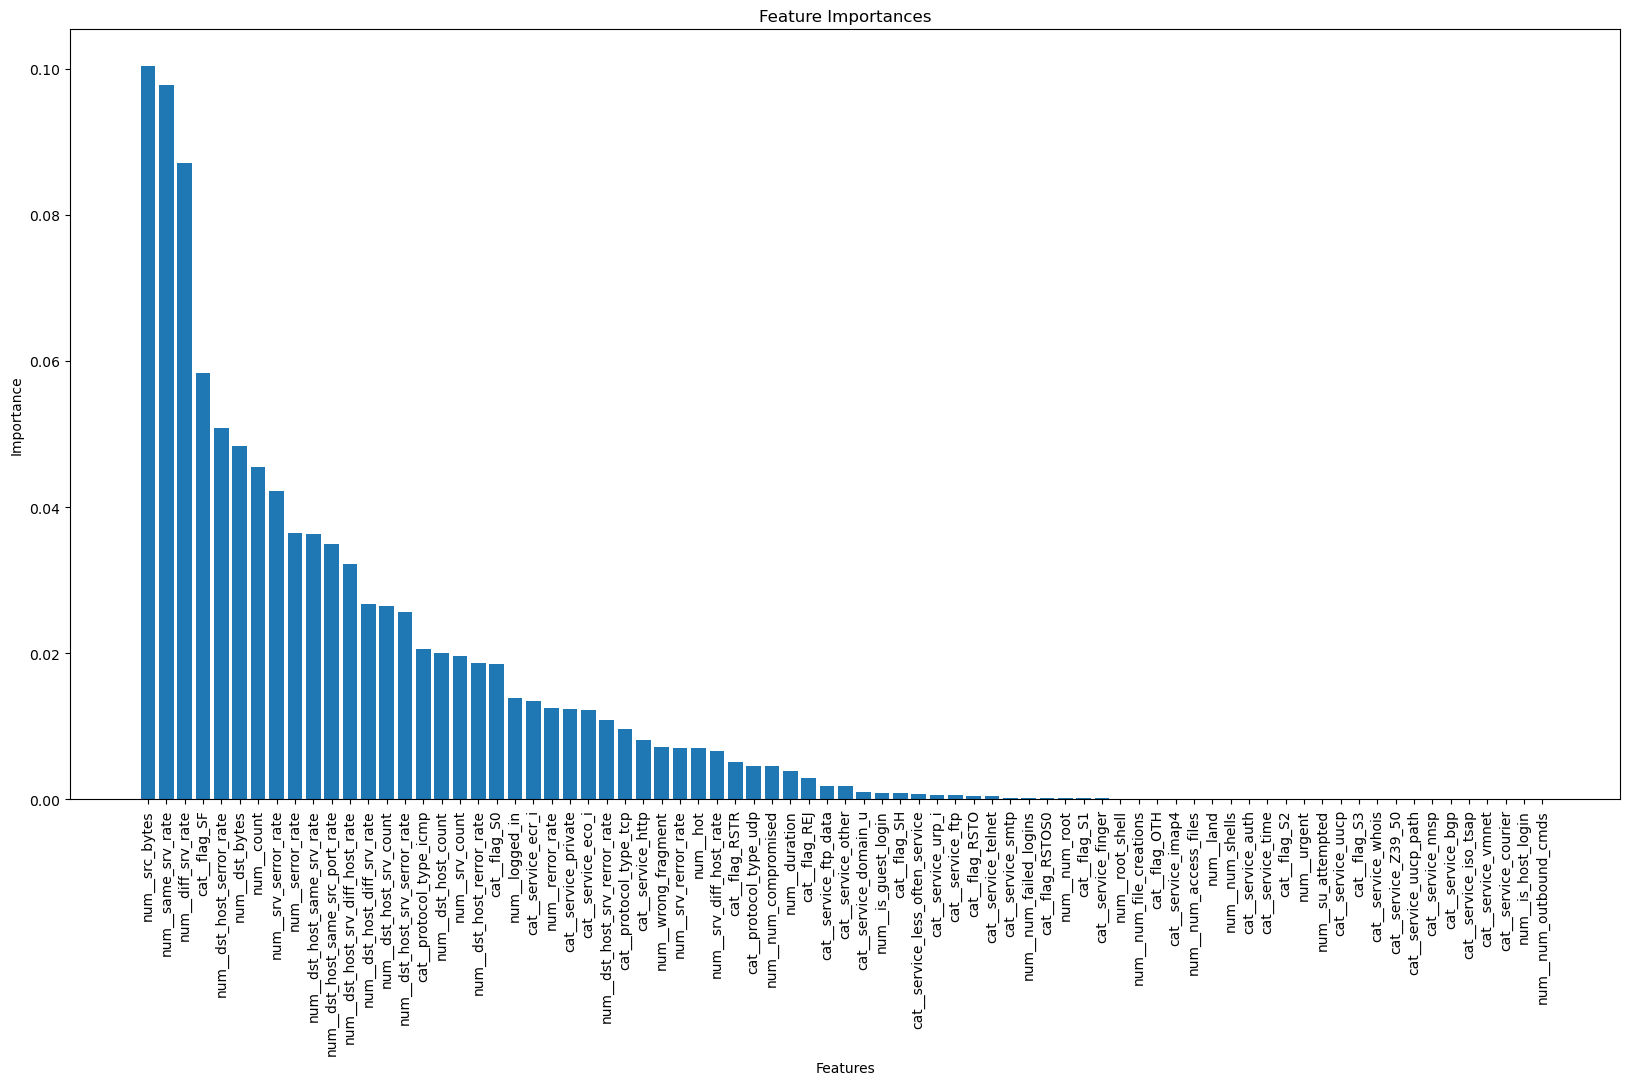

In [ ]:
# Plot the feature importances as a bar chart
plt.figure(figsize=(20, 10))
plt.bar(importances_df_sorted['Feature'], importances_df_sorted['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# To construct new DataFrame after all the Preprocessing is done
def X_transformed_df(X_data, input_feature, features):
    cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_feature)
    transformed_column_names = np.concatenate((features, cat_feature_names), axis=0)
    X_transformed = preprocessor.transform(X_data)
    X_transformed_df = pd.DataFrame(X_transformed, columns=transformed_column_names)
    return X_transformed_df

In [ ]:
# Get the preprocessed DataFrames for train and test sets
X_train_transformed_df = X_transformed_df(X_train, input_cat_features, num_features)
X_test_transformed_df = X_transformed_df(X_test, input_cat_features, num_features)
# print(X_train_transformed_df)

In [ ]:
# ----------------------- SELCTING BEST COMBINATION OF FEATURES----------------------
results = []
for num_features in range(1, len(sorted_idx) + 1):
    # Select the top k features
    top_k_features = sorted_idx[-num_features:]

    # Train a new Random Forest classifier using the top k features
    rf_k = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=28)
    rf_k.fit(X_train_transformed_df.iloc[:, top_k_features], y_train)

    # Make predictions on the test set using the top k features
    test_preds = rf_k.predict(X_test_transformed_df.iloc[:, top_k_features])

    # Calculate the accuracy of the predictions
    accuracy = accuracy_score(y_test, test_preds)

    # Store the results
    """
        results stores the list of tuple:
        1st element = Number of most Important Features
        2nd element = Accuracy when using that number of combined features
        (65, 0.9981742409208176) = This means, combination of 65 most important features give 0.9981 accuracy
    """
    results.append((num_features, accuracy))

In [ ]:
# Find the best feature combination based on the highest accuracy
best_result = max(results, key=lambda x: x[1])      # This will store the feature combination with highest accuracy
# (65, 0.9981742409208176)
best_num_features_combination = best_result[0]   # Stores the number of best feature combination
best_accuracy = best_result[1]                   # Store the respective accuracy when combining the best combination
print("This is Best Accuracy and Combination after Feature Selection:", best_result)
# Get the best feature combination
best_features = sorted_idx[-best_num_features_combination:]     # This means [-65:] = last 65 elements

This is Best Accuracy and Combination after Feature Selection: (41, 0.9140791341376863)


In [ ]:
print("Best feature combination: ", best_features)
print("Length of Best feature combination: ", len(best_features), "\n")

Best feature combination:  [18 45 56 50 67  0  9 40 70 27  6 24  4 51 39 37 46 57 23 47  8 71 36 20
 28 38 35 29 31 33 32 30 21 22 19  2 34 75 26 25  1]
Length of Best feature combination:  41 



In [ ]:
# -----------------------Mutual Information-----------------------
# Applying Mutual Information on the best feature combination

X_train_best_combination = X_train_transformed_df.iloc[:, best_features]
X_test_best_combination = X_test_transformed_df.iloc[:, best_features]
# print(X_train_best_combination)

In [ ]:
#  Compute the mutual information scores for the best feature combination
mutual_info_scores = mutual_info_classif(X_train_best_combination, y_train)

In [ ]:
# Choose a threshold for MI scores (e.g., using the 25th percentile)
mi_threshold = np.percentile(mutual_info_scores, 30)

In [ ]:
# Filter the features based on the MI threshold
selected_features_indices = np.where(mutual_info_scores > mi_threshold)
X_train_selected = X_train_best_combination.iloc[:, selected_features_indices[0]]
X_test_selected = X_test_best_combination.iloc[:, selected_features_indices[0]]
print(X_train_selected)

        srv_diff_host_rate  service_http  protocol_type_tcp  \
0                -0.374560           0.0                1.0   
1                -0.374560           0.0                0.0   
2                -0.374560           0.0                1.0   
3                -0.374560           1.0                1.0   
4                -0.028179           1.0                1.0   
...                    ...           ...                ...   
125968           -0.374560           0.0                1.0   
125969           -0.374560           0.0                0.0   
125970           -0.374560           0.0                1.0   
125971           -0.374560           0.0                1.0   
125972           -0.374560           0.0                1.0   

        dst_host_srv_rerror_rate  service_eco_i  service_private  rerror_rate  \
0                      -0.376387            0.0              0.0    -0.374362   
1                      -0.376387            0.0              0.0    -0.374362   


In [ ]:
# Get the names of the selected features
selected_feature_names = X_train_best_combination.columns[selected_features_indices]
print(selected_feature_names)

Index(['srv_diff_host_rate', 'service_http', 'protocol_type_tcp',
       'dst_host_srv_rerror_rate', 'service_eco_i', 'service_private',
       'rerror_rate', 'logged_in', 'flag_S0', 'dst_host_rerror_rate',
       'srv_count', 'dst_host_count', 'protocol_type_icmp',
       'dst_host_srv_serror_rate', 'dst_host_srv_count',
       'dst_host_diff_srv_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_same_src_port_rate', 'dst_host_same_srv_rate', 'serror_rate',
       'srv_serror_rate', 'count', 'dst_bytes', 'dst_host_serror_rate',
       'flag_SF', 'diff_srv_rate', 'same_srv_rate', 'src_bytes'],
      dtype='object')


In [ ]:
# Train a new Random Forest classifier using the selected features
rf_selected = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf_selected.fit(X_train_selected, y_train)

    # Make predictions on the test set using the selected features
y_pred_selected = rf_selected.predict(X_test_selected)

In [ ]:
# Calculate the accuracy of the predictions
accuracy_selected = accuracy_score(y_test, y_pred_selected)
final_best_precision = precision_score(y_test, y_pred_selected, average='weighted')
final_best_recall = recall_score(y_test, y_pred_selected, average='weighted')
final_best_f1 = f1_score(y_test, y_pred_selected, average='weighted')
roc_auc = multiclass_roc_auc_score(y_test, y_pred_selected)

In [ ]:
print("Best accuracy: {0}".format(accuracy_selected))
print("Best precision: {0}".format(final_best_precision))
print("Best recall: {0}".format(final_best_recall))
print("Best F1-score: {0}".format(final_best_f1))
print("Multiclass ROC AUC: {0}".format(roc_auc))
print("OOB: ", rf_selected.oob_score_)

Best accuracy: 0.9138573456352023
Best precision: 0.8732811646631999
Best recall: 0.9138573456352023
Best F1-score: 0.8764022380635528
Multiclass ROC AUC: 0.9196357997644597
OOB:  0.9982297793971724


In [ ]:
# Classification Report provides individual Precision, Recall and F1-Score of each and every Classes
print("Classification Report:", "\n", classification_report(y_test, y_pred_selected, zero_division=0))

Classification Report: 
                  precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       228
           back       0.85      0.99      0.91       227
buffer_overflow       1.00      0.41      0.58        17
      ftp_write       1.00      0.50      0.67         2
   guess_passwd       1.00      0.02      0.04       411
     httptunnel       0.00      0.00      0.00        41
           imap       1.00      1.00      1.00         2
        ipsweep       0.94      1.00      0.97       479
           land       1.00      0.50      0.67         2
     loadmodule       1.00      0.75      0.86         4
       mailbomb       0.00      0.00      0.00        94
          mscan       0.00      0.00      0.00       310
       multihop       1.00      0.11      0.20         9
          named       0.00      0.00      0.00         2
        neptune       0.99      1.00      1.00      6654
           nmap       0.99      0.99      0.99       206
     

In [ ]:
# Plotting of ROC Curves of 22 Classes
def plot_multiclass_roc_auc_plotly(y_test, y_pred, n_classes, classes_names):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_bin = lb.transform(y_test)
    y_pred_bin = lb.transform(y_pred)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = [cm.tab20(i) for i in range(n_classes)]  # Generate the colors
    fig = sp.make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter'}]])
    for i, color in zip(range(n_classes), colors):
        fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', name=f'{classes_names[i]} (AUC = {roc_auc[i]:.2f})', line=dict(color=f'rgba{color}')))
    fig.add_shape(type='line', x0=0, x1=1, y0=0, y1=1, yref='y', xref='x', line=dict(color='Black', dash='dash'))
    fig.update_layout(
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        title={
        'text': "Multiclass ROC AUC Curve",
        'y': 1,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
        showlegend=True,
        legend=dict(orientation='h', yanchor='bottom', xanchor='right', y=1, x=1)
    )
    fig.show()

In [ ]:
class_report = classification_report(y_test, y_pred_selected, zero_division=0)
classification_report_str = str(class_report)

In [ ]:
# Extract class names using regex
class_names = (re.findall(r'^\s*([\w\d_]+)\s', classification_report_str, re.MULTILINE))[1:-3]
n_classes = len(np.unique(y_test))
plot_multiclass_roc_auc_plotly(y_test, y_pred_selected, n_classes, class_names)

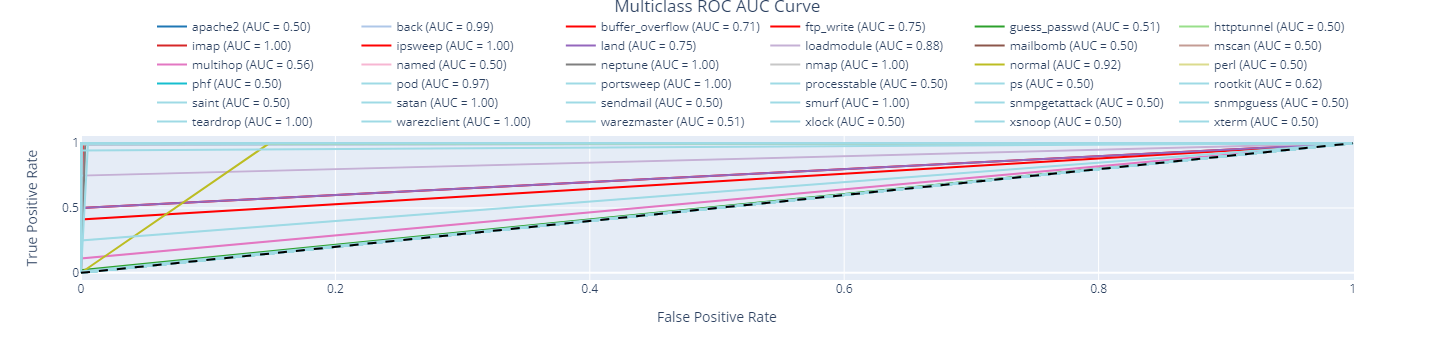